In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle as pkl
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import Normalizer,MinMaxScaler,LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import pickle

In [27]:
data=pd.read_csv("Train.csv")
data.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [28]:
data.shape

(10999, 12)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [30]:
data.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

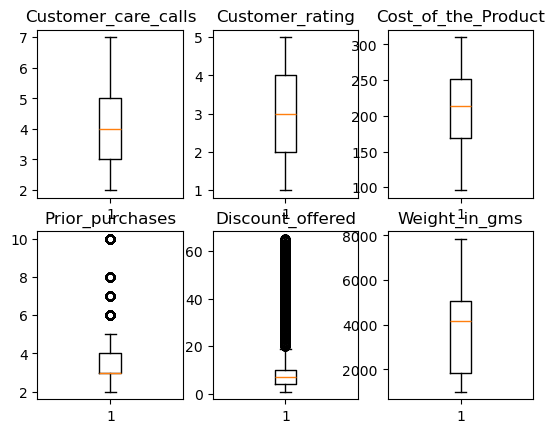

In [31]:
#Identifying Outliers
c=1
for i in data.columns[1:-1]:
    if not(data[i].dtype=='object'):
        plt.subplot(2,3,c)
        plt.boxplot(data[i])
        plt.title(i)
        c=c+1
plt.show()

Outlier count= 1003


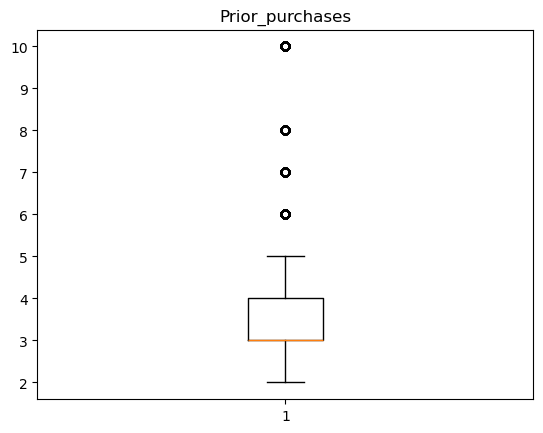

Outlier count= 2209


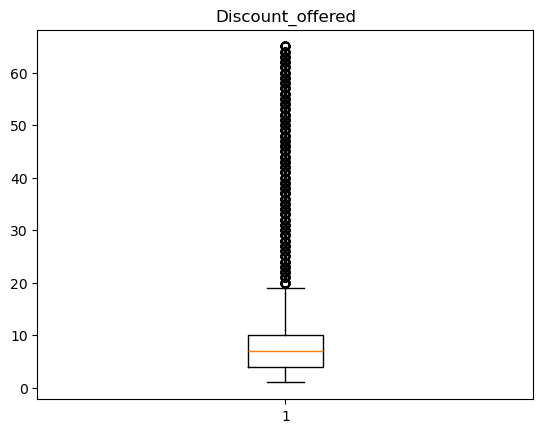

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [32]:
#Treating outliers
data2=data.copy()
def outlier_removal(data_column):
    #data_column=np.log10(data_column)
    q1=np.percentile(data_column,25)
    #print(q1)
    q3=np.percentile(data_column,75)
    #print(q3)
    iqr=q3-q1
    loc_cnt=0
    outlier_cnt=0
    values=[]
    for val in data_column:
        if val>q3+(1.5*iqr) or val<q1-(1.5*iqr):
            outlier_cnt+=1
            '''
            data2.drop(data2.index[loc_cnt],inplace=True)
            data.drop(data2.index[loc_cnt],inplace=True)
            '''
        
        values+=[val]
    loc_cnt+=1
            
    print("Outlier count=",outlier_cnt)
    
    plt.boxplot(values)
    plt.title(data_column.name)
    plt.show()
    #print(data_column)
    return values
data2.Prior_purchases=outlier_removal(data2.Prior_purchases)
data2.Discount_offered=outlier_removal(data2.Discount_offered)

data2.head()


In [33]:
#univariate analysis
data2.describe(include='all')

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999,10999,10999.000000,10999.000000,10999.000000,10999.000000,10999,10999,10999.000000,10999.000000,10999.000000
unique,NaN,5,3,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN
top,NaN,F,Ship,NaN,NaN,NaN,NaN,low,F,NaN,NaN,NaN
freq,NaN,3666,7462,NaN,NaN,NaN,NaN,5297,5545,NaN,NaN,NaN
mean,5500.00000,NaN,NaN,4.054459,2.990545,210.196836,3.567597,NaN,NaN,13.373216,3634.016729,0.596691
std,3175.28214,NaN,NaN,1.141490,1.413603,48.063272,1.522860,NaN,NaN,16.205527,1635.377251,0.490584
min,1.00000,NaN,NaN,2.000000,1.000000,96.000000,2.000000,NaN,NaN,1.000000,1001.000000,0.000000
25%,2750.50000,NaN,NaN,3.000000,2.000000,169.000000,3.000000,NaN,NaN,4.000000,1839.500000,0.000000
50%,5500.00000,NaN,NaN,4.000000,3.000000,214.000000,3.000000,NaN,NaN,7.000000,4149.000000,1.000000
75%,8249.50000,NaN,NaN,5.000000,4.000000,251.000000,4.000000,NaN,NaN,10.000000,5050.000000,1.000000


In [34]:
'''
#Scaling down values
cols_to_normalize=['Prior_purchases','Discount_offered','Weight_in_gms','Cost_of_the_Product']

with open('cols_to_normalize','wb') as f:
    pickle.dump(cols_to_normalize,f)

for col in cols_to_normalize:
    #normalizer=Normalizer(norm='l1')
    normalizer=MinMaxScaler()
    col_data=data2[col].values
    normalizer.fit([col_data.T])
    with open('Normalizer_'+col,'wb') as f:
        pickle.dump(normalizer,f)
    #data2[col]=normalizer.transform(data2[col])
    data2[col]=normalizer.transform([col_data.T])[0]

data2.head(100)
data2.describe()
'''

"\n#Scaling down values\ncols_to_normalize=['Prior_purchases','Discount_offered','Weight_in_gms','Cost_of_the_Product']\n\nwith open('cols_to_normalize','wb') as f:\n    pickle.dump(cols_to_normalize,f)\n\nfor col in cols_to_normalize:\n    #normalizer=Normalizer(norm='l1')\n    normalizer=MinMaxScaler()\n    col_data=data2[col].values\n    normalizer.fit([col_data.T])\n    with open('Normalizer_'+col,'wb') as f:\n        pickle.dump(normalizer,f)\n    #data2[col]=normalizer.transform(data2[col])\n    data2[col]=normalizer.transform([col_data.T])[0]\n\ndata2.head(100)\ndata2.describe()\n"

['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

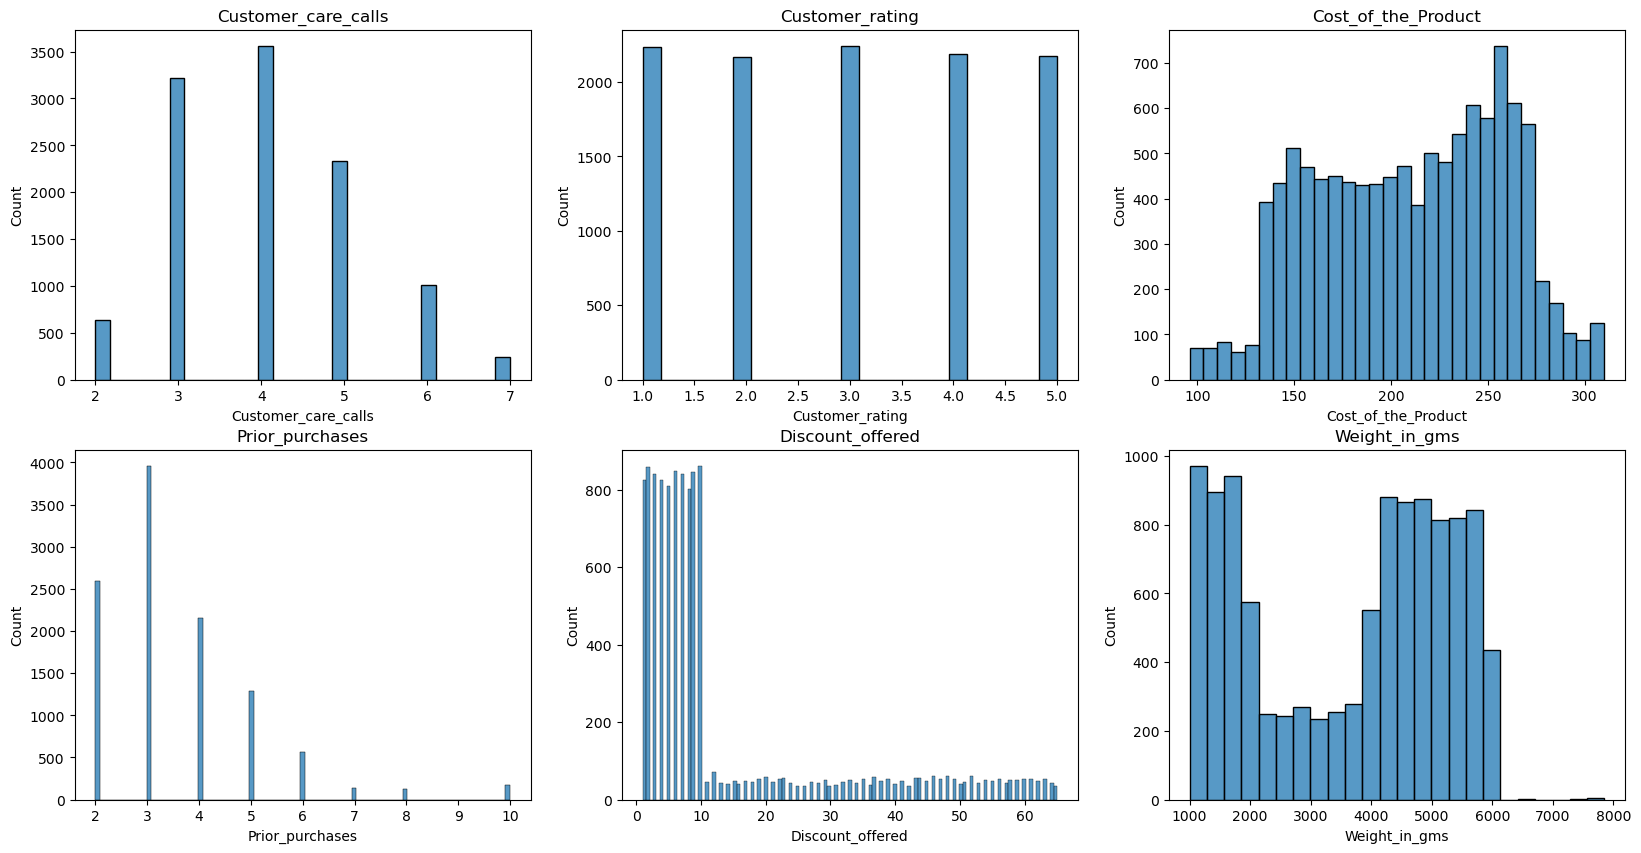

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

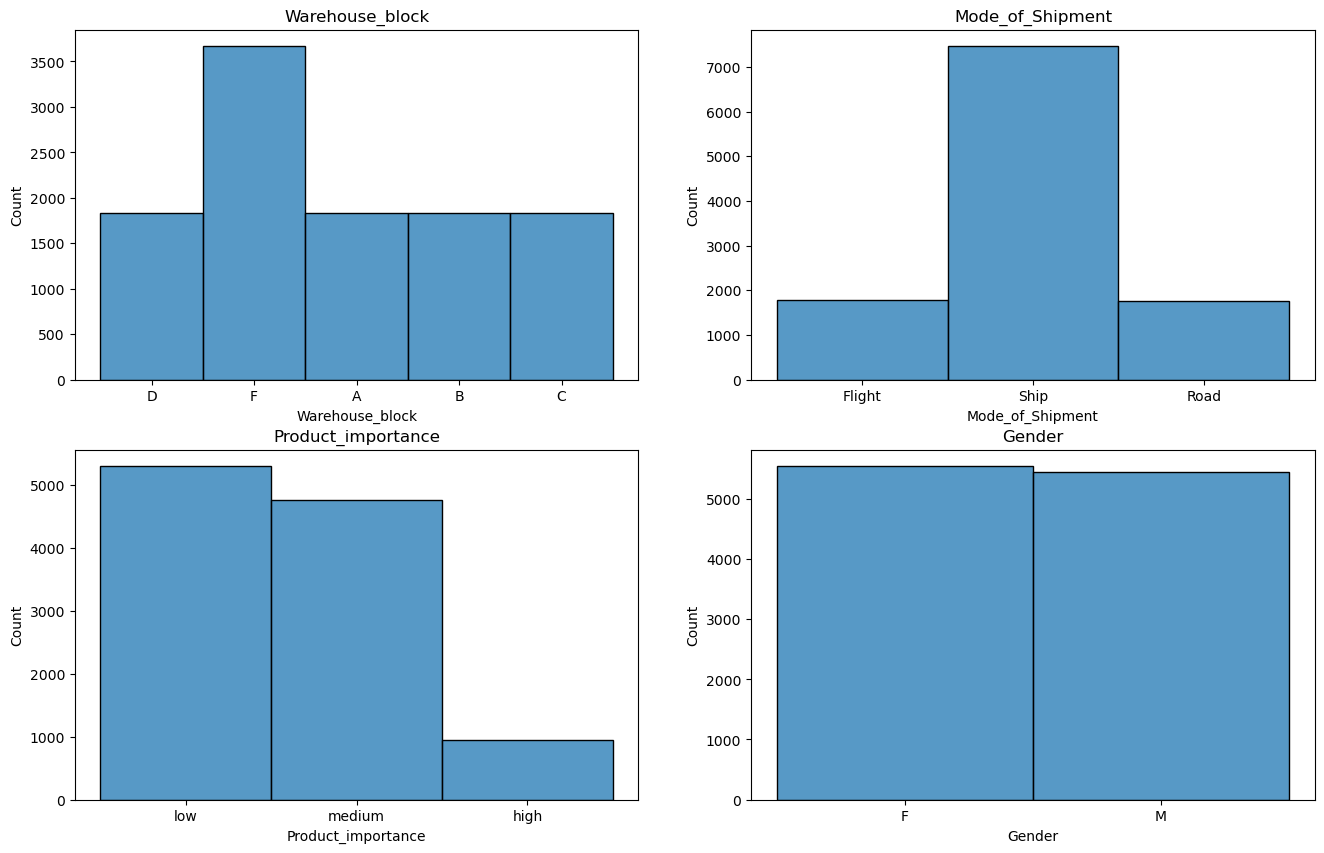

In [35]:
#Univariate Analysis
cols_to_plot=['Customer_care_calls','Customer_rating','Cost_of_the_Product','Prior_purchases','Discount_offered','Weight_in_gms']
'''Index(['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms'],
      dtype='object')'''
print(cols_to_plot)
fig, axes = plt.subplots(2, 3,figsize=(20,10))

cnt=0
for i in range(2):
    for j in range(3):
        sns.histplot(data[cols_to_plot[cnt]],ax=axes[i,j])
        axes[i,j].set_title(cols_to_plot[cnt])
        cnt+=1
plt.show()
cols_to_plot=['Warehouse_block','Mode_of_Shipment','Product_importance','Gender']
fig, axes = plt.subplots(2, 2,figsize=(16,10))

cnt=0
for i in range(2):
    for j in range(2):
        sns.histplot(data[cols_to_plot[cnt]],ax=axes[i,j])
        axes[i,j].set_title(cols_to_plot[cnt])
        cnt+=1
plt.show()

In [36]:
#Bivariate Analysis



In [37]:
#Label Encoding
data_label_encoded=data2.copy()
cols_to_encode=['Warehouse_block','Mode_of_Shipment','Product_importance','Gender']
for col in cols_to_encode:
    lbe=LabelEncoder()
    lbe.fit(data_label_encoded[col])
    with open('Label_Encoder_'+col+'.pkl','wb') as f:
        pickle.dump(lbe,f)
    data_label_encoded[col]=lbe.transform(data_label_encoded[col])
data_label_encoded.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,3,0,4,2,177,3,1,0,44,1233,1
1,2,4,0,4,5,216,2,1,1,59,3088,1
2,3,0,0,2,2,183,4,1,1,48,3374,1
3,4,1,0,3,3,176,4,2,1,10,1177,1
4,5,2,0,2,2,184,3,2,0,46,2484,1


In [38]:
with open('cols_to_encode','wb') as f:
    pickle.dump(cols_to_encode,f)

In [39]:
'''#Scaling down
scaler=MinMaxScaler()
scaler.fit(data_label_encoded.values)
with open('Min_Max_Scaler','wb') as f:
    pickle.dump(scaler,f)
data_label_encoded[data_label_encoded.columns]=scaler.transform(data_label_encoded.values)
data_label_encoded.head()
'''

"#Scaling down\nscaler=MinMaxScaler()\nscaler.fit(data_label_encoded.values)\nwith open('Min_Max_Scaler','wb') as f:\n    pickle.dump(scaler,f)\ndata_label_encoded[data_label_encoded.columns]=scaler.transform(data_label_encoded.values)\ndata_label_encoded.head()\n"

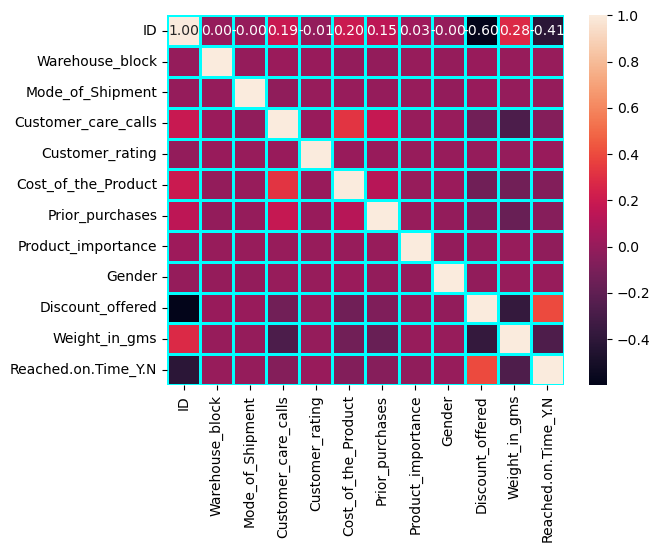

In [40]:
#Multivariate Analysis

data_label_encoded.corr()
sns.heatmap(data=data_label_encoded.corr(),linecolor='aqua',linewidths=2,fmt=".2f",annot=True,)
plt.show()

In [41]:
selected_features=['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance',  'Weight_in_gms']
#'Gender', 'Discount_offered',
X_train,X_test,Y_train,Y_test=train_test_split(data_label_encoded[data_label_encoded.columns[1:-1]].values,data_label_encoded[data_label_encoded.columns[-1]].values,test_size=0.2,shuffle=True,random_state=1234)
scaler=MinMaxScaler()
scaler.fit(X_train)
with open('Min_Max_Scaler.pkl','wb') as f:
    pickle.dump(scaler,f)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(8799, 10)
(2200, 10)
(8799,)
(2200,)


In [42]:
lg=LogisticRegression(max_iter=1000)
lg.fit(X_train,Y_train)
print("LogisticRegression Training Score=",lg.score(X_train,Y_train))
print("LogisticRegression Test Score=",lg.score(X_test,Y_test))

LogisticRegression Training Score= 0.642459370382998
LogisticRegression Test Score= 0.639090909090909


In [43]:
lcv=LogisticRegressionCV(max_iter=1000)
lcv.fit(X_train,Y_train)
print("LogisticRegressionCV Training Score=",lcv.score(X_train,Y_train))
print("LogisticRegressionCV Test Score=",lcv.score(X_test,Y_test))

LogisticRegressionCV Training Score= 0.6431412660529605
LogisticRegressionCV Test Score= 0.6381818181818182


In [44]:
xgb=XGBClassifier()
xgb.fit(X_train,Y_train)
print("XGBoost Training Score=",xgb.score(X_train,Y_train))
print("XGBoost Test Score=",xgb.score(X_test,Y_test))

XGBoost Training Score= 0.9136265484714172
XGBoost Test Score= 0.6368181818181818


In [45]:
rg=RidgeClassifier()
rg.fit(X_train,Y_train)
print("RidgeClassifier Training Score=",rg.score(X_train,Y_train))
print("RidgeClassifier Test Score=",rg.score(X_test,Y_test))

RidgeClassifier Training Score= 0.6530287532674167
RidgeClassifier Test Score= 0.649090909090909


In [46]:
knn=KNeighborsClassifier()
knn.fit(X_train,Y_train)
print("KNN Training Score=",knn.score(X_train,Y_train))
print("KNN Test Score=",knn.score(X_test,Y_test))

KNN Training Score= 0.7769064666439368
KNN Test Score= 0.6359090909090909


In [47]:
rfc=RandomForestClassifier()
rfc.fit(X_train,Y_train)
print("RandomForestClassifier Training Score=",rfc.score(X_train,Y_train))
print("RandomForestClassifier Test Score=",rfc.score(X_test,Y_test))

RandomForestClassifier Training Score= 1.0
RandomForestClassifier Test Score= 0.6581818181818182


In [48]:
svc=svm.SVC()
svc.fit(X_train,Y_train)
print("SVM Classifier Training Score=",svc.score(X_train,Y_train))
print("SVM Classifier Test Score=",svc.score(X_test,Y_test))

SVM Classifier Training Score= 0.6907603136720082
SVM Classifier Test Score= 0.6495454545454545


In [49]:
models_dict={
    "LogisticRegression":lg,
    "LogisticRegressionCV":lcv,
    "XGBClassifier":xgb,
    "RidgeClassifier":rg,
    "KNeighborsClassifier":knn,
    "RandomForestClassifier":rfc,
    "SVMClassifier":svc
}

evaluation_list=[]
for model in models_dict.keys():
    y_pred=models_dict[model].predict(X_test)
    row_eval_list=[model]
    row_eval_list+=[round(accuracy_score(y_true=Y_test,y_pred=y_pred)*100,2)]
    row_eval_list+=[round(f1_score(y_true=Y_test,y_pred=y_pred)*100,2)]
    row_eval_list+=[round(recall_score(y_true=Y_test,y_pred=y_pred)*100,2)]
    row_eval_list+=[round(precision_score(y_true=Y_test,y_pred=y_pred)*100,2)]
    evaluation_list+=[row_eval_list]

evaluation_df=pd.DataFrame(data=evaluation_list,columns=['ModelName','Accuracy','f1_score','Recall','Precision'])
evaluation_df

,ModelName,Accuracy,f1_score,Recall,Precision
0,LogisticRegression,63.91,69.03,67.87,70.24
1,LogisticRegressionCV,63.82,69.00,67.94,70.09
2,XGBClassifier,63.68,68.38,66.26,70.65
3,RidgeClassifier,64.91,69.89,68.71,71.11
4,KNeighborsClassifier,63.59,68.67,67.33,70.07
5,RandomForestClassifier,65.82,68.93,63.96,74.73
6,SVMClassifier,64.95,66.32,58.21,77.06


In [53]:
final_model=models_dict['RandomForestClassifier']
with open('Ml_Model.pkl','wb') as f:
    pickle.dump(final_model,f)